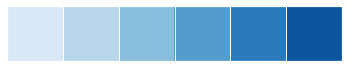

In [22]:
# coding: utf-8
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
import seaborn as sns
import gc
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
sns.palplot(sns.color_palette("Blues"))
sns.set_style('whitegrid')
sns.set(font_scale=2)

In [20]:
def load_dataset(DATA_PATH):
    train_label = pd.read_csv(DATA_PATH+'train_label.csv')
    train_base = pd.read_csv(DATA_PATH+'train_base.csv')
    test_base = pd.read_csv(DATA_PATH+'test_a_base.csv')

    train_op = pd.read_csv(DATA_PATH+'train_op.csv')
    train_trans = pd.read_csv(DATA_PATH+'train_trans.csv')
    test_op = pd.read_csv(DATA_PATH+'test_a_op.csv')
    test_trans = pd.read_csv(DATA_PATH+'test_a_trans.csv')

    return train_label, train_base, test_base, train_op, train_trans, test_op, test_trans

def transform_time(x):
    day = int(x.split(' ')[0])
    hour = int(x.split(' ')[2].split('.')[0].split(':')[0])
    minute = int(x.split(' ')[2].split('.')[0].split(':')[1])
    second = int(x.split(' ')[2].split('.')[0].split(':')[2])
    return 86400*day+3600*hour+60*minute+second

def data_preprocess(DATA_PATH):
    train_label, train_base, test_base, train_op, train_trans, test_op, test_trans = load_dataset(DATA_PATH=DATA_PATH)
    # 拼接数据
    train_df = train_base.copy()
    test_df = test_base.copy()
    train_df = train_label.merge(train_df, on=['user'], how='left')
    del train_base, test_base

    op_df = pd.concat([train_op, test_op], axis=0, ignore_index=True)
    trans_df = pd.concat([train_trans, test_trans], axis=0, ignore_index=True)
    data = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    del train_op, test_op, train_df, test_df
    # 时间维度的处理
    op_df['days_diff'] = op_df['tm_diff'].apply(lambda x: int(x.split(' ')[0]))
    trans_df['days_diff'] = trans_df['tm_diff'].apply(lambda x: int(x.split(' ')[0]))
    op_df['timestamp'] = op_df['tm_diff'].apply(lambda x: transform_time(x))
    trans_df['timestamp'] = trans_df['tm_diff'].apply(lambda x: transform_time(x))
    op_df['hour'] = op_df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[0]))
    trans_df['hour'] = trans_df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[0]))
    trans_df['week'] = trans_df['days_diff'].apply(lambda x: x % 7)
    # 排序
    trans_df = trans_df.sort_values(by=['user', 'timestamp'])
    op_df = op_df.sort_values(by=['user', 'timestamp'])
    trans_df.reset_index(inplace=True, drop=True)
    op_df.reset_index(inplace=True, drop=True)

    gc.collect()
    return data, op_df, trans_df

def gen_user_amount_features(df):
    group_df = df.groupby(['user'])['amount'].agg([
        ('user_amount_mean', 'mean'),
        ('user_amount_std', 'std'),
        ('user_amount_max', 'max'),
        ('user_amount_min', 'min'),
        ('user_amount_sum', 'sum'),
        ('user_amount_med', 'median'),
        ('user_amount_cnt', 'count')
    ]).reset_index()
    return group_df

def gen_user_group_amount_features(df, value):
    group_df = df.pivot_table(index='user',
                              columns=value,
                              values='amount',
                              dropna=False,
                              aggfunc=['count', 'sum']).fillna(0)
    group_df.columns = ['user_{}_{}_amount_{}'.format(value, f[1], f[0]) for f in group_df.columns]
    group_df.reset_index(inplace=True)

    return group_df

def gen_user_window_amount_features(df, window):
    group_df = df[df['days_diff']>window].groupby('user')['amount'].agg([
        ('user_amount_mean_{}d'.format(window), 'mean'),
        ('user_amount_std_{}d'.format(window), 'std'),
        ('user_amount_max_{}d'.format(window), 'max'),
        ('user_amount_min_{}d'.format(window), 'min'),
        ('user_amount_sum_{}d'.format(window), 'sum'),
        ('user_amount_med_{}d'.format(window), 'median'),
        ('user_amount_cnt_{}d'.format(window), 'count'),
    ]).reset_index()
    return group_df

def gen_user_nunique_features(df, value, prefix):
    group_df = df.groupby(['user'])[value].agg([
        ('user_{}_{}_nuniq'.format(prefix, value), 'nunique')
    ]).reset_index()
    return group_df

def gen_user_null_features(df, value, prefix):
    df['is_null'] = 0
    df.loc[df[value].isnull(), 'is_null'] = 1

    group_df = df.groupby(['user'])['is_null'].agg([('user_{}_{}_null_cnt'.format(prefix, value), 'sum'),
                                                    ('user_{}_{}_null_ratio'.format(prefix, value), 'mean')]).reset_index()
    return group_df

def gen_user_tfidf_features(df, value):
    df[value] = df[value].astype(str)
    df[value].fillna('-1', inplace=True)
    group_df = df.groupby(['user']).apply(lambda x: x[value].tolist()).reset_index()
    group_df.columns = ['user', 'list']
    group_df['list'] = group_df['list'].apply(lambda x: ','.join(x))
    enc_vec = TfidfVectorizer()
    tfidf_vec = enc_vec.fit_transform(group_df['list'])
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2020)
    vec_svd = svd_enc.fit_transform(tfidf_vec)
    vec_svd = pd.DataFrame(vec_svd)
    vec_svd.columns = ['svd_tfidf_{}_{}'.format(value, i) for i in range(10)]
    group_df = pd.concat([group_df, vec_svd], axis=1)
    del group_df['list']
    return group_df

def gen_user_countvec_features(df, value):
    df[value] = df[value].astype(str)
    df[value].fillna('-1', inplace=True)
    group_df = df.groupby(['user']).apply(lambda x: x[value].tolist()).reset_index()
    group_df.columns = ['user', 'list']
    group_df['list'] = group_df['list'].apply(lambda x: ','.join(x))
    enc_vec = CountVectorizer()
    tfidf_vec = enc_vec.fit_transform(group_df['list'])
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2020)
    vec_svd = svd_enc.fit_transform(tfidf_vec)
    vec_svd = pd.DataFrame(vec_svd)
    vec_svd.columns = ['svd_countvec_{}_{}'.format(value, i) for i in range(10)]
    group_df = pd.concat([group_df, vec_svd], axis=1)
    del group_df['list']
    return group_df

def kfold_stats_feature(train, test, feats, k):
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=2020)  # 这里最好和后面模型的K折交叉验证保持一致

    train['fold'] = None
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['label'])):
        train.loc[val_idx, 'fold'] = fold_

    kfold_features = []
    for feat in feats:
        nums_columns = ['label']
        for f in nums_columns:
            colname = feat + '_' + f + '_kfold_mean'
            kfold_features.append(colname)
            train[colname] = None
            for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['label'])):
                tmp_trn = train.iloc[trn_idx]
                order_label = tmp_trn.groupby([feat])[f].mean()
                tmp = train.loc[train.fold == fold_, [feat]]
                train.loc[train.fold == fold_, colname] = tmp[feat].map(order_label)
                # fillna
                global_mean = train[f].mean()
                train.loc[train.fold == fold_, colname] = train.loc[train.fold == fold_, colname].fillna(global_mean)
            train[colname] = train[colname].astype(float)

        for f in nums_columns:
            colname = feat + '_' + f + '_kfold_mean'
            test[colname] = None
            order_label = train.groupby([feat])[f].mean()
            test[colname] = test[feat].map(order_label)
            # fillna
            global_mean = train[f].mean()
            test[colname] = test[colname].fillna(global_mean)
            test[colname] = test[colname].astype(float)
    del train['fold']
    return train, test

def mode_count(x):
    try:
        return x.value_counts().iloc[0]
    except Exception:
        return np.nan
    
def gen_op_features(df):
    df['days'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[0]))
    df['hour'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[0]))
    df['minute'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[1]))
    df['second'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[2]))
    op_group = df.groupby(['user']).agg({'op_type':['nunique'],
                               'op_mode':['nunique'],
                               'op_device':['nunique',lambda x:x.isnull().sum()/len(x)],
                                'ip':['nunique',lambda x:x.isnull().sum()/len(x)],
                               'net_type':['nunique',lambda x:x.isnull().sum()/len(x)],
                                'channel':['nunique',lambda x:x.isnull().sum()/len(x)],
                               'ip_3':['nunique',lambda x:x.isnull().sum()/len(x)],
                                'days':['max','min','mean','std','skew','median','nunique','count'],
                                'hour':['max','min','mean','std','skew','median','nunique']})
    op_group.columns = ['user_{}_{}'.format(f[1], f[0]) for f in op_group.columns]
    op_group.reset_index(inplace=True)
    return op_group
    
def gen_trans_features(df):
#     df['days'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[0]))
#     df['hour'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[0]))
#     df['minute'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[1]))
#     df['second'] = df['tm_diff'].apply(lambda x: int(x.split(' ')[2].split('.')[0].split(':')[2]))
#     trans_group = df.groupby(['user']).agg({
#                                'tunnel_in':[lambda x:x.isnull().sum()/len(x)],
#                                 'tunnel_out':[lambda x:x.isnull().sum()/len(x)],
#                                'ip':[lambda x:x.isnull().sum()/len(x)],
#                                 'type2':[lambda x:x.isnull().sum()/len(x)],
#                                'ip_3':[lambda x:x.isnull().sum()/len(x)],
#                                 'days':['max','min','mean','std','skew','median','nunique','count'],
#                                 'hour':['max','min','mean','std','skew','median','nunique'],})
    trans_group1 = df.groupby(['user'])['type1'].apply(lambda x:(np.sum((x=='45a1168437c708ff'))+1)/
                                                       (np.sum((x=='f67d4b5a05a1352a'))+1)).reset_index()
    trans_group1.rename(columns = {'type1':'trans_type1_count1'},inplace=True)
    trans_group2 = df.groupby(['user'])['type1'].apply(lambda x:(np.sum((x=='f67d4b5a05a1352a'))+1)/
                                                       (np.sum((x=='674e8d5860bc033d'))+1)).reset_index()
    trans_group2.rename(columns = {'type1':'trans_type1_count2'},inplace=True)

    trans_group = pd.merge(trans_group1,trans_group2,on='user')
    return trans_group

def gen_features(df, op, trans):
    df.drop(['service3_level'], axis=1, inplace=True)
    # base
    df['product7_fail_ratio'] = df['product7_fail_cnt'] / df['product7_cnt']
    df['city_count'] = df.groupby(['city'])['user'].transform('count')
    df['province_count'] = df.groupby(['province'])['user'].transform('count')
    # trans
    df = df.merge(gen_user_amount_features(trans), on=['user'], how='left')
    for col in tqdm(['days_diff', 'platform', 'tunnel_in', 'tunnel_out', 'type1', 'type2', 'ip', 'ip_3']):
        df = df.merge(gen_user_nunique_features(df=trans, value=col, prefix='trans'), on=['user'], how='left')
    df['user_amount_per_days'] = df['user_amount_sum'] / df['user_trans_days_diff_nuniq']
    df['user_amount_per_cnt'] = df['user_amount_sum'] / df['user_amount_cnt']
    df = df.merge(gen_user_group_amount_features(df=trans, value='platform'), on=['user'], how='left')
    df = df.merge(gen_user_group_amount_features(df=trans, value='type1'), on=['user'], how='left')
    df = df.merge(gen_user_group_amount_features(df=trans, value='type2'), on=['user'], how='left')
    df = df.merge(gen_user_window_amount_features(df=trans, window=27), on=['user'], how='left')
    df = df.merge(gen_user_window_amount_features(df=trans, window=23), on=['user'], how='left')
    df = df.merge(gen_user_window_amount_features(df=trans, window=15), on=['user'], how='left')
    df = df.merge(gen_user_null_features(df=trans, value='ip', prefix='trans'), on=['user'], how='left')
    group_df = trans[trans['type1']=='45a1168437c708ff'].groupby(['user'])['days_diff'].agg([('user_type1_45a1168437c708ff_min_day', 'min')]).reset_index()
    df = df.merge(group_df, on=['user'], how='left')
    df = df.merge(gen_trans_features(df=trans), on=['user'], how='left')
    # op
    df = df.merge(gen_op_features(df=op), on=['user'], how='left')
    df = df.merge(gen_user_tfidf_features(df=op, value='op_mode'), on=['user'], how='left')
    df = df.merge(gen_user_tfidf_features(df=op, value='op_type'), on=['user'], how='left')
    df = df.merge(gen_user_countvec_features(df=op, value='op_mode'), on=['user'], how='left')
    df = df.merge(gen_user_countvec_features(df=op, value='op_type'), on=['user'], how='left')
    # LabelEncoder
    cat_cols = []
    for col in tqdm([f for f in df.select_dtypes('object').columns if f not in ['user']]):
        le = LabelEncoder()
        df[col].fillna('-1', inplace=True)
        df[col] = le.fit_transform(df[col])
        cat_cols.append(col)

    return df

def lgb_model(train, target, test, k):
    feats = [f for f in train.columns if f not in ['user', 'label']]
    print('Current num of features:', len(feats))
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=2020)
    oof_probs = np.zeros(train.shape[0])
    output_preds = 0
    offline_score = []
    feature_importance_df = pd.DataFrame()
    parameters = {
        'learning_rate': 0.05,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 63,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'min_data_in_leaf': 20,
        'verbose': -1,
        'nthread': 8
    }

    for i, (train_index, test_index) in enumerate(folds.split(train, target)):
        train_y, test_y = target[train_index], target[test_index]
        train_X, test_X = train[feats].iloc[train_index, :], train[feats].iloc[test_index, :]

        dtrain = lgb.Dataset(train_X,
                             label=train_y)
        dval = lgb.Dataset(test_X,
                           label=test_y)
        lgb_model = lgb.train(
                parameters,
                dtrain,
                num_boost_round=5000,
                valid_sets=[dval],
                early_stopping_rounds=100,
                verbose_eval=100,
        )
        oof_probs[test_index] = lgb_model.predict(test_X[feats], num_iteration=lgb_model.best_iteration)
        offline_score.append(lgb_model.best_score['valid_0']['auc'])
        output_preds += lgb_model.predict(test[feats], num_iteration=lgb_model.best_iteration)/folds.n_splits
        print(offline_score)
        # feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = lgb_model.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('OOF-MEAN-AUC:%.6f, OOF-STD-AUC:%.6f' % (np.mean(offline_score), np.std(offline_score)))
    print('feature importance:')
    print(feature_importance_df.groupby(['feature'])['importance'].mean().sort_values(ascending=False).head(15))

    return output_preds, oof_probs, np.mean(offline_score)

if __name__ == '__main__':
    DATA_PATH = ''
    print('读取数据...')
    data, op_df, trans_df = data_preprocess(DATA_PATH=DATA_PATH)

    print('开始特征工程...')
    data = gen_features(data, op_df, trans_df)
    data['city_level'] = data['city'].map(str) + '_' + data['level'].map(str)
    data['city_balance_avg'] = data['city'].map(str) + '_' + data['balance_avg'].map(str)


    print('开始模型训练...')
    train = data[~data['label'].isnull()].copy()
    target = train['label']
    test = data[data['label'].isnull()].copy()

    target_encode_cols = ['province', 'city', 'city_level', 'city_balance_avg']
    train, test = kfold_stats_feature(train, test, target_encode_cols, 5)
    train.drop(['city_level', 'city_balance_avg'], axis=1, inplace=True)
    test.drop(['city_level', 'city_balance_avg'], axis=1, inplace=True)

    lgb_preds, lgb_oof, lgb_score = lgb_model(train=train, target=target, test=test, k=5)

    sub_df = test[['user']].copy()
    sub_df['prob'] = lgb_preds
    sub_df.to_csv('sub.csv', index=False)

读取数据...
开始特征工程...


100%|██████████| 24/24 [00:00<00:00, 43.72it/s]


开始模型训练...
Current num of features: 241
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.73547
[200]	valid_0's auc: 0.735118
Early stopping, best iteration is:
[111]	valid_0's auc: 0.736317
[0.7363168645931792]
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.728962
[200]	valid_0's auc: 0.729672
Early stopping, best iteration is:
[199]	valid_0's auc: 0.729864
[0.7363168645931792, 0.7298641435624037]
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.724144
[200]	valid_0's auc: 0.726642
Early stopping, best iteration is:
[190]	valid_0's auc: 0.726995
[0.7363168645931792, 0.7298641435624037, 0.7269952013770986]
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.726942
[200]	valid_0's auc: 0.727991
Early stopping, best iteration is:
[129]	valid_0's auc: 0.728561
[0.7363168645931792, 0.7298641435624037, 0.7269952013770986, 0.728561179494435]
Training un

In [7]:
OOF-MEAN-AUC:0.724657, OOF-STD-AUC:0.006138
OOF-MEAN-AUC:0.728658, OOF-STD-AUC:0.005717
OOF-MEAN-AUC:0.729382

In [21]:
feature_importance_df

NameError: name 'feature_importance_df' is not defined

In [25]:
const_features = [col for col in train.columns if len(train[col].unique()) == 1]
len(const_features)

0

In [26]:
quasi_features = [col for col in train.columns if (train[col].value_counts() / len(train)).values[0] > 0.9999]
len(quasi_features)

0

In [27]:
dub_features = []
tick = 0
for i in range(len(train.columns)):
    tick += 1
    if tick%10 == 0:
        print(tick)
    
    for j in range(i+1,len(train.columns)):
        col_1 = train.columns[i]
        col_2 = train.columns[j]
        if train[col_1].equals(train[col_2]):
            dub_features.append(col_2)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [28]:
dub_features

['user_type2_dde9095123fb6968_amount_count',
 'user_type2_1b1caf20bfafadf7_amount_sum',
 'user_type2_dde9095123fb6968_amount_sum',
 'user_type2_1b1caf20bfafadf7_amount_sum',
 'user_type2_dde9095123fb6968_amount_sum',
 'user_type2_dde9095123fb6968_amount_sum',
 'user_<lambda_0>_ip_3']

In [29]:
def correlation(dataset,threshold):
    corr_features = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix)):
        for j in range(i):
            if abs(corr_matrix.iloc[i][j]) > threshold:
                corr_features.add(dataset.columns[i])
    return corr_features

In [30]:
corr_features = correlation(train,0.95)

In [31]:
corr_features

{'user_amount_per_days',
 'user_amount_sum_27d',
 'user_nunique_ip_3',
 'user_nunique_op_type',
 'user_trans_ip_nuniq',
 'user_type1_3146295fbf43c0cb_amount_count',
 'user_type1_674e8d5860bc033d_amount_count',
 'user_type1_674e8d5860bc033d_amount_sum',
 'user_type1_81abaafd1ae512dd_amount_sum',
 'user_type1_b26bc49195bd79cf_amount_sum',
 'user_type1_e5cd41dfa47665b1_amount_count',
 'user_type1_e5cd41dfa47665b1_amount_sum',
 'user_type1_f67d4b5a05a1352a_amount_count',
 'user_type2_08d5d580f39e34e6_amount_sum',
 'user_type2_1b1caf20bfafadf7_amount_count',
 'user_type2_1b1caf20bfafadf7_amount_sum',
 'user_type2_2ee592ab06090eb5_amount_sum',
 'user_type2_81abaafd1ae512dd_amount_count',
 'user_type2_81abaafd1ae512dd_amount_sum',
 'user_type2_b26bc49195bd79cf_amount_count',
 'user_type2_b26bc49195bd79cf_amount_sum'}

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

feats = [f for f in train.columns if f not in ['user', 'label']]
roc_values = []
for feature in train[feats].columns:
    clf = DecisionTreeClassifier()
    train[feature].fillna(train[feature].mean(),inplace=True)
    clf.fit(train[feature][:35000].to_frame(),target[:35000])
    pos_prob = clf.predict_proba(train[feature][35000:].to_frame())
    roc = roc_auc_score(target[35000:],pos_prob[:,1])
    roc_values.append(roc)

In [42]:
roc_values = pd.Series(roc_values)
roc_values.index = train[feats].columns
roc_values.sort_values(ascending = False)

user_trans_ip_nuniq                            0.635494
user_trans_ip_3_nuniq                          0.635109
user_trans_ip_null_ratio                       0.631128
user_trans_type1_nuniq                         0.630453
user_type1_f67d4b5a05a1352a_amount_count       0.629057
user_platform_42573d7287a8c9c2_amount_count    0.628929
user_amount_cnt_15d                            0.627648
user_amount_cnt                                0.624058
user_trans_platform_nuniq                      0.619145
user_type1_19d44f1a51919482_amount_count       0.617149
user_amount_min_15d                            0.610248
user_amount_min                                0.610181
user_type2_11a213398ee0c623_amount_count       0.609846
user_trans_days_diff_nuniq                     0.609276
user_platform_46c69cbbce5f1568_amount_count    0.607656
user_nunique_channel                           0.606518
agreement_total                                0.606180
user_type1_674e8d5860bc033d_amount_sum         0

In [7]:
train

,user,label,sex,age,provider,level,verified,using_time,regist_type,card_a_cnt,card_b_cnt,card_c_cnt,agreement1,op1_cnt,op2_cnt,card_d_cnt,agreement_total,service1_cnt,service1_amt,service2_cnt,agreement2,agreement3,agreement4,acc_count,login_cnt_period1,login_cnt_period2,ip_cnt,login_cnt_avg,login_days_cnt,province,city,balance,balance_avg,balance1,balance1_avg,balance2,balance2_avg,service3,product1_amount,product2_amount,product3_amount,product4_amount,product5_amount,product6_amount,product7_cnt,product7_fail_cnt,product7_fail_ratio,city_count,province_count,user_amount_mean,user_amount_std,user_amount_max,user_amount_min,user_amount_sum,user_amount_med,user_amount_cnt,user_trans_days_diff_nuniq,user_trans_platform_nuniq,user_trans_tunnel_in_nuniq,user_trans_tunnel_out_nuniq,user_trans_type1_nuniq,user_trans_type2_nuniq,user_trans_ip_nuniq,user_trans_ip_3_nuniq,user_amount_per_days,user_amount_per_cnt,user_platform_42573d7287a8c9c2_amount_count,user_platform_46c69cbbce5f1568_amount_count,user_platform_71b24e4fd9a658ee_amount_count,user_platform_80f6d63f26a56315_amount_count,user_platform_cc79bc9b7f4885de_amount_count,user_platform_fe8686492bb72dd4_amount_count,user_platform_42573d7287a8c9c2_amount_sum,user_platform_46c69cbbce5f1568_amount_sum,user_platform_71b24e4fd9a658ee_amount_sum,user_platform_80f6d63f26a56315_amount_sum,user_platform_cc79bc9b7f4885de_amount_sum,user_platform_fe8686492bb72dd4_amount_sum,user_type1_0a3cf8dac7dca9d1_amount_count,user_type1_0f99a10a1331ce14_amount_count,user_type1_19d44f1a51919482_amount_count,user_type1_2a2edd435db5ac70_amount_count,user_type1_3146295fbf43c0cb_amount_count,user_type1_33e9d4cef01499e1_amount_count,user_type1_443b0fd0860c21b6_amount_count,user_type1_45a1168437c708ff_amount_count,user_type1_674e8d5860bc033d_amount_count,user_type1_71b24e4fd9a658ee_amount_count,user_type1_81abaafd1ae512dd_amount_count,user_type1_8adb3dcfea9dcf5e_amount_count,user_type1_b26bc49195bd79cf_amount_count,user_type1_c68ff01f3f65797d_amount_count,user_type1_cd31880f9fa923ea_amount_count,user_type1_dde9095123fb6968_amount_count,user_type1_e5cd41dfa47665b1_amount_count,user_type1_f67d4b5a05a1352a_amount_count,user_type1_fc4eca960f6c690c_amount_count,user_type1_fc9b75cf62ba8b8f_amount_count,user_type1_0a3cf8dac7dca9d1_amount_sum,user_type1_0f99a10a1331ce14_amount_sum,user_type1_19d44f1a51919482_amount_sum,user_type1_2a2edd435db5ac70_amount_sum,user_type1_3146295fbf43c0cb_amount_sum,user_type1_33e9d4cef01499e1_amount_sum,user_type1_443b0fd0860c21b6_amount_sum,user_type1_45a1168437c708ff_amount_sum,user_type1_674e8d5860bc033d_amount_sum,user_type1_71b24e4fd9a658ee_amount_sum,user_type1_81abaafd1ae512dd_amount_sum,user_type1_8adb3dcfea9dcf5e_amount_sum,user_type1_b26bc49195bd79cf_amount_sum,user_type1_c68ff01f3f65797d_amount_sum,user_type1_cd31880f9fa923ea_amount_sum,user_type1_dde9095123fb6968_amount_sum,user_type1_e5cd41dfa47665b1_amount_sum,user_type1_f67d4b5a05a1352a_amount_sum,user_type1_fc4eca960f6c690c_amount_sum,user_type1_fc9b75cf62ba8b8f_amount_sum,user_type2_08d5d580f39e34e6_amount_count,user_type2_11a213398ee0c623_amount_count,user_type2_1b1caf20bfafadf7_amount_count,user_type2_2a2edd435db5ac70_amount_count,user_type2_2bf61669e40ef6b8_amount_count,user_type2_2dd805cd09533f85_amount_count,user_type2_2e774c57ed375d33_amount_count,user_type2_2ee592ab06090eb5_amount_count,user_type2_81abaafd1ae512dd_amount_count,user_type2_a906ce5a502c748e_amount_count,user_type2_b26bc49195bd79cf_amount_count,user_type2_b5a8be737a50b171_amount_count,user_type2_cd31880f9fa923ea_amount_count,user_type2_dde9095123fb6968_amount_count,user_type2_08d5d580f39e34e6_amount_sum,user_type2_11a213398ee0c623_amount_sum,user_type2_1b1caf20bfafadf7_amount_sum,user_type2_2a2edd435db5ac70_amount_sum,user_type2_2bf61669e40ef6b8_amount_sum,user_type2_2dd805cd09533f85_amount_sum,user_type2_2e774c57ed375d33_amount_sum,user_type2_2ee592ab06090eb5_amount_sum,user_type2_81abaafd1ae512dd_amount_sum,user_type2_a906ce5a502c748e_amount_sum,us